# CartPole solution with Bins

In this solution we are going to solve the cart pole environment by using quanti states, in other words a set of states that or finite. This is known as binning the states. Because the number of actions and states of the cart pole task is relatively small when we focus on only the information that is critical we can use tabular Q learning to solve the environment

In [20]:
import gym
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gym import wrappers
from datetime import datetime


<h2>Implimentation</h2>

First we will impliment our accesory methods.

build_state:
this method converts an array of integers into one unique number. Eg [1,2,3,4] -> 1234. This is achieved by taking the array of integers as a string of integers, then converting then string to its int representation.This allows us to turn our current state into a usable number

to_bin:
This will take in a value and an array of possible bins. It then decides which bin the value belongs in.

In [21]:
def build_state(features):
    return int("".join(map(lambda feature: str(int(feature)), features)))

def to_bin(value, bins):
    return np.digitize(x=[value], bins=bins)[0]

<h3>Feature Transformer Class</h3>

Next we are going to create a transform class similar to the one in scikit-learn. This will transform 1 observation at a time. 

In [46]:
class FeatureTransformer:
  def __init__(self):
    # Note: to make this better you could look at how often each bin was
    # actually used while running the script.
    # It's not clear from the high/low values nor sample() what values
    # we really expect to get.
    self.cart_position_bins = np.linspace(-2.4, 2.4, 9)
    self.cart_velocity_bins = np.linspace(-2, 2, 9) # (-inf, inf) (I did not check that these were good values)
    self.pole_angle_bins = np.linspace(-0.4, 0.4, 9)
    self.pole_velocity_bins = np.linspace(-3.5, 3.5, 9) # (-inf, inf) (I did not check that these were good values)

  def transform(self, observation):
    # returns an int
    cart_pos, cart_vel, pole_angle, pole_vel = observation
    return build_state([
      to_bin(cart_pos, self.cart_position_bins),
      to_bin(cart_vel, self.cart_velocity_bins),
      to_bin(pole_angle, self.pole_angle_bins),
      to_bin(pole_vel, self.pole_velocity_bins),
    ])

    
    

<h3>Model class</h3>

Takes in environment and feature transformer. The models constructor initialises the Q table with a shape of num_states x num_actions, this will be 10^4 as there are 10 bins for each of the 4 states and 2 as there are only 2 possible actions to take.

predict:
this transforms the state into integer X and we use that to index Q. Predict will return the Q of this particular state over all actions. We will then take the max of this.

update:
Here we will convert the state into an integer and update the Q table using gradient descent

sample_action:
Here we impliment epsilon greedy. This involves deciding wether or not to explore new combinations or exploit optimal values we have already learned from so far. This is determined by the probability of epsilon. 

In [47]:
class Model:
    def __init__(self, env, feature_transformer):
        self.env = env
        self.ft = feature_transformer
        
        num_states = 10**env.observation_space.shape[0]
        num_actions = env.action_space.n
        
        #fills the Q table with random values for the combination of states and actions
        self.Q = np.random.uniform(low=-1, high=1, size=(num_states,num_actions))
        
    def predict(self, s):
        x = self.ft.transform(s)
        return self.Q[x]
    
    def update(self, s, a, G):
        x = self.ft.transform(s)
        self.Q[x,a] += 10e-3*(G - self.Q[x,a])
        
    def sample_action(self, s, eps):
        if np.random.random() < eps:
            return self.env.action_space.sample()
        else :
            p = self.predict(s)
            return np.argmax(p)

<h3>Play Methods</h3>

play_one: First we want to play a single episode of the game. This will take in our model, epsilon value and our gamma value. Gamma (discount rate) is used to calculate how much our model should value future rewards. A model with a low gamma value will prioritise immediate rewards, where as a high gamma value will prioritise the future over the current state. Extremes in either direction are not good and the ideal gamma value for a model can vary. We will loop through 10000 time frames (the CartPole-v1 caps this at 600 but older versions can do 10000) and chose an action from the model. We set the previous observation variable to the current observation and then update our observation, reward, done and info variables from carrying out our action in the environment. We then add the reward of that action to our totals rewards array. Next we are going to apply a large penalty of -300 if the pole falls before 200 time frames. Finally we update our model using the Q learning equation. When the loop is done we return the total reward.


In [48]:
def play_one(model, eps, gamma):
    observation = env.reset()
    done = False
    total_rewards = 0
    iterations = 0
    cap = 10000
    
    while not done and iterations < cap:
        action = model.sample_action(observation, eps)
        prev_observation = observation
        observation, reward, done, info = env.step(action)
        
        total_rewards += reward
        
        if done and iterations < 199:
            reward = -300
        
        G = reward + gamma*np.max(model.predict(observation))
        model.update(prev_observation, action, G)
        
        iterations += 1
        
    return total_rewards

<h3>Plot the graph </h3>

Now that we have our model agent pretty much finished, we are going to add a method for plotting out the running average. We want to see the average returns over 100 episodes as this is how OpenAi judges the efficiency and performance of your bot.


In [49]:
def plot_running_avg(total_rewards):
    N = len(total_rewards)
    running_avg = np.empty(N)
    
    for t in range(N):
        running_avg[t] = total_rewards[max(0, t-100):(t+1)].mean()
    plt.plot(running_avg)
    plt.title("Running Average")
    plt.show()

[2017-10-02 16:05:48,209] Making new env: CartPole-v1


('episode:', 0, 'total reward:', 16.0, 'eps:', 1.0)
('episode:', 100, 'total reward:', 14.0, 'eps:', 0.099503719020998915)
('episode:', 200, 'total reward:', 29.0, 'eps:', 0.070534561585859828)
('episode:', 300, 'total reward:', 51.0, 'eps:', 0.057639041770423498)
('episode:', 400, 'total reward:', 50.0, 'eps:', 0.049937616943892232)
('episode:', 500, 'total reward:', 122.0, 'eps:', 0.044676705160877031)
('episode:', 600, 'total reward:', 113.0, 'eps:', 0.040790850822400207)
('episode:', 700, 'total reward:', 54.0, 'eps:', 0.037769478730024897)
('episode:', 800, 'total reward:', 99.0, 'eps:', 0.035333262666878668)
('episode:', 900, 'total reward:', 202.0, 'eps:', 0.033314830232638482)
('episode:', 1000, 'total reward:', 172.0, 'eps:', 0.031606977062050699)
('episode:', 1100, 'total reward:', 78.0, 'eps:', 0.030137438733945612)
('episode:', 1200, 'total reward:', 96.0, 'eps:', 0.028855492841238062)
('episode:', 1300, 'total reward:', 120.0, 'eps:', 0.027724348650071385)
('episode:', 140

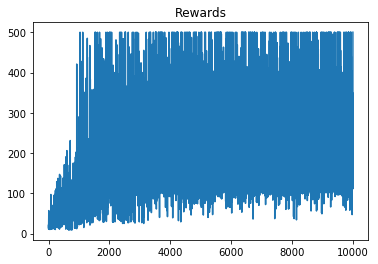

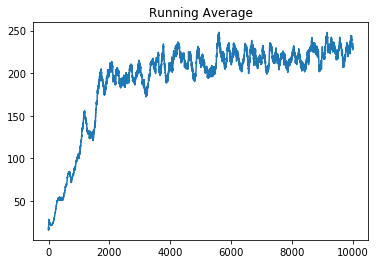

In [53]:
if __name__ == '__main__':
  env = gym.make('CartPole-v1')
  ft = FeatureTransformer()
  model = Model(env, ft)
  gamma = 0.9

  if 'monitor' in sys.argv:
    filename = os.path.basename(__file__).split('.')[0]
    monitor_dir = './' + filename + '_' + str(datetime.now())
    env = wrappers.Monitor(env, monitor_dir)

  N = 10000
  totalrewards = np.empty(N)
  for n in range(N):
    eps = 1.0/np.sqrt(n+1)
    totalreward = play_one(model, eps, gamma)
    totalrewards[n] = totalreward
    if n % 100 == 0:
      print("episode:", n, "total reward:", totalreward, "eps:", eps)
  print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
  print("total steps:", totalrewards.sum())

  plt.plot(totalrewards)
  plt.title("Rewards")
  plt.show()

  plot_running_avg(totalrewards)

This example is based off the lessons provided by the Lazy Programmers course Advanced AI:Deep Reinforcement Learning. https://www.udemy.com/deep-reinforcement-learning-in-python/